# WWV/H Test Signal Generator
original MATLAB code by KD8OXT  
Ported to Python by KB3UMD

In [1]:
import wave

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.signal import chirp, spectrogram

In [2]:
Fs = 48000 # samples per second
dt = 1/Fs # seconds per sample
StopTime = 2 # seconds
t = np.arange(0, StopTime - dt, dt)

In [3]:
t

array([0.00000000e+00, 2.08333333e-05, 4.16666667e-05, ...,
       1.99991667e+00, 1.99993750e+00, 1.99995833e+00])

In [4]:
# (name, duration in seconds) pairs
signal_sequence = [
    ('voice_annoucement', 10),
    ('gaussian_white_noise', 2),
    ('blank', 1),
    ('phase_coherent_sine_waves', 10),
    ('blank', 1),
    ('chirp_sequence', 8),
    ('blank', 2),
    ('bursts', 2),
    ('blank', 1),
    ('gaussian_white_noise', 2),
    ('blank', 3)
]

total signal duration:

In [5]:
sum([x[1] for x in signal_sequence])

42

## Segments

Generate white noise:

In [6]:
# use the legacy random number generator which might match up
# better with MATLAB results
def gaussian_white_noise() -> np.ndarray:
    noise = np.random.standard_normal(Fs*StopTime)
    # normalize to prevent clipping:
    normalized = noise / np.amax(np.abs(noise))
    print(f"White noise: {len(normalized) / Fs} seconds.")
    return normalized

gaussian_white_noise()

White noise: 2.0 seconds.


array([ 0.42915109, -0.06618148,  0.03383217, ...,  0.22164033,
       -0.28253439,  0.37252955])

In [7]:
# Phase-locked audio signals:
# Tones of 2 kHz, 3 kHz, 4 kHz and 5 kHz (they said that they have 
# transmitted 5 kHz in the past). All tones on at the same time and 
# the same amplitude, then down by 3 dB, then down by 10 dB.
tones = [2000, 3000, 4000, 5000] # Hertz


def phase_coherent_sine_waves() -> np.ndarray:
    t = np.arange(0, 1, dt) # 1 second
    single = np.add.reduce(
        [np.cos(2 * np.pi * f * t) for f in tones])
    single = .25 * single # avoid clipping
    
    # attenuate by 3 dB, down to ~-30 dB
    seq = np.concatenate([
        single / (np.sqrt(2)) ** x for x in range(0, 10)
    ])
    
    print(f"Coherent tones: {len(seq) / Fs} seconds.")
    return seq
    
    
phase_coherent_sine_waves()

Coherent tones: 10.0 seconds.


array([1.        , 0.88729603, 0.58298781, ..., 0.0078125 , 0.02576466,
       0.03921331])

Let's see the final results:

In [8]:
y2 = phase_coherent_sine_waves()

Coherent tones: 10.0 seconds.


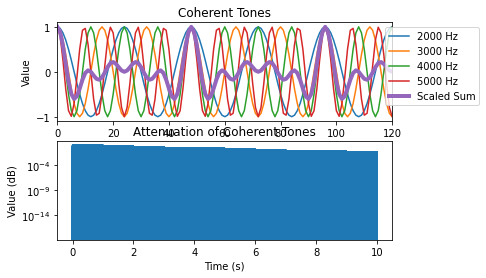

In [9]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(np.cos(2 * np.pi * 2000 * np.arange(0, 1 - dt, dt)))
axs[0].plot(np.cos(2 * np.pi * 3000 * np.arange(0, 1 - dt, dt)))
axs[0].plot(np.cos(2 * np.pi * 4000 * np.arange(0, 1 - dt, dt)))
axs[0].plot(np.cos(2 * np.pi * 5000 * np.arange(0, 1 - dt, dt)))
axs[0].plot(y2, linewidth = 4)
axs[0].legend([f"{x} Hz" for x in tones] + ['Scaled Sum'],
             bbox_to_anchor = (1.275, 1),
             loc = "upper right")
axs[0].set_xlim(0, 120)
axs[0].set_xlabel("Samples")
axs[0].set_ylabel("Value")
axs[0].set_title("Coherent Tones")

axs[1].semilogy(np.arange(0, len(y2) / Fs, dt), y2)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Value (dB)")
axs[1].set_title("Attenuation of Coherent Tones")

plt.show()

todo: spacing

In [10]:
long_chirp = 1 # seconds
short_chirp = .05 # seconds

# linear chirps betweeen 0 and 5 kHz
def _chirp(length: str, direction: str) -> np.ndarray:
    if length == 'short':
        end = short_chirp
    elif length == 'long':
        end = long_chirp
    else:
        raise ValueError()
    t1 = end
        
    if direction == 'up':
        f0 = 0
        f1 = 5000
    elif direction == 'down':
        f0 = 5000
        f1 = 0
    else:
        raise ValueError()
    
    t = np.arange(0, end, dt)
    return chirp(t, f0, t1, f1)

In [11]:
len(_chirp('short', 'up'))

2400

In [12]:
seq = [
    ('short', 'up'),
    ('short', 'down'),
    ('large_space',),
    ('long', 'up'),
    ('long', 'down')
]
repeat = 3
small_space = .1 # seconds
large_space = .5 # seconds

def chirp_sequence() -> np.ndarray:
    result = []
    
    for subsequence in seq:
        if subsequence[0] == 'large_space':
            result.append(np.zeros(int(large_space * Fs)))
        else:
            for _ in range(repeat):
                result.append(_chirp(*subsequence))
                result.append(np.zeros(int(small_space * Fs)))
    
    # compile all the chirps:
    chirps = np.concatenate(result)
    
    
    # End the chirp sequence on an even second:
    print(f"Adding {(len(chirps) / Fs % 1)} seconds of blank "
          "time to end on an even second...")
    chirps = np.concatenate([chirps,
                            np.zeros((len(chirps) % Fs))])
    print(f"The chirps take {len(chirps) / Fs} seconds total.")
    return chirps
    
chirp_sequence()

Adding 0.0 seconds of blank time to end on an even second...
The chirps take 8.0 seconds total.


array([1.        , 0.99999999, 0.99999985, ..., 0.        , 0.        ,
       0.        ])

In [13]:
assert len(chirp_sequence()) == Fs * 8

Adding 0.0 seconds of blank time to end on an even second...
The chirps take 8.0 seconds total.


Plot chirps:

In [14]:
# from SciPy docs
def plot_spectrogram(title, w, fs):
    ff, tt, Sxx = spectrogram(w, fs=fs, nperseg=256, nfft=576)
    plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='gray_r', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()

Adding 0.0 seconds of blank time to end on an even second...
The chirps take 8.0 seconds total.


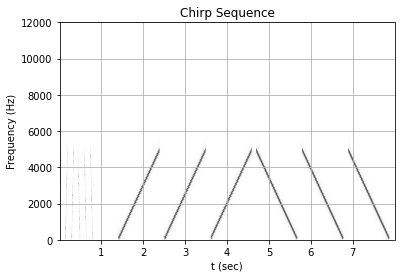

In [15]:
plot_spectrogram("Chirp Sequence", chirp_sequence(), Fs)

In [16]:
# One cycle bursts:
def _burst(frequency):
    t = np.arange(0, 1 / frequency, dt)
    spike = np.sin(2 * np.pi * frequency * t)
    
    return spike

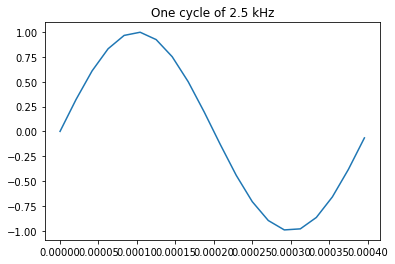

In [17]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(0, 1 / 2500, dt), np.sin(2 * np.pi * 2500 * np.arange(0, 1 / 2500, dt)))
ax.set_title("One cycle of 2.5 kHz")
plt.show()

In [18]:
burst_frequencies = [2500, 5000] # Hertz
spike_count = 5

def bursts() -> np.ndarray:
    results = []
    
    for freq in burst_frequencies:
        # preallocate a second to add spikes into
        y = np.zeros(Fs)
    
        spike = _burst(freq)
        for n in np.arange(Fs / (spike_count + 1),
                           Fs - len(spike),
                           Fs / (spike_count + 1)):
            y[int(n) : int(n) + len(spike)] = spike
        
        results.append(y)
    
    sequence = np.concatenate(results)
    print(f"Pulses: {len(sequence) / Fs} seconds.")
    return sequence

bursts()

Pulses: 2.0 seconds.


array([0., 0., 0., ..., 0., 0., 0.])

Plot bursts:

Pulses: 2.0 seconds.


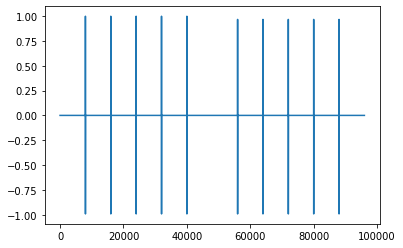

In [19]:
fig, ax = plt.subplots(1,1)
ax.plot(bursts())
plt.show()

Pulses: 2.0 seconds.


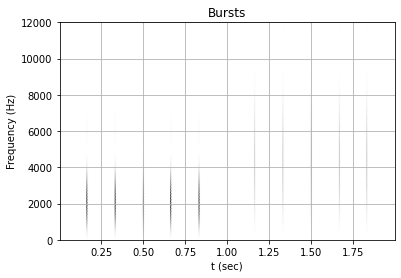

In [20]:
plot_spectrogram('Bursts', bursts(), Fs)
plt.show()

In [21]:
x = np.array([1, 2, 3, 4])

In [22]:
x[1] = -1
x

array([ 1, -1,  3,  4])

In [23]:
x[1:3] = [-2, -2]
x

array([ 1, -2, -2,  4])

In [24]:
def blank(duration: int) -> np.ndarray:
    return np.zeros(int(duration * Fs))

In [25]:
assert len(blank(1)) == Fs * 1
assert len(blank(2)) == Fs * 2

In [26]:
rate, data = scipy.io.wavfile.read('voiceintro.wav')
assert rate == Fs
data

<ipython-input-26-900b0db68406>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = scipy.io.wavfile.read('voiceintro.wav')


array([-38, -43, -47, ..., 183, 193, 206], dtype=int16)

In [27]:
def voice_annoucement() -> np.ndarray:
    voice = np.zeros(Fs * 10) # preallocate 10 seconds
    
#     with wave.open("voiceintro.wav", 'rb') as f:
#         assert f.getframerate() == Fs
#         voice_audio = f.readframes(f.getnframes())
    rate, voice_audio = scipy.io.wavfile.read('voiceintro.wav')
    assert rate == Fs
    
    voice[0 : len(voice_audio)] = voice_audio
    voice = voice / np.max(np.abs(voice)) # add amplitude
    
    print(f"Voice clip: {len(voice) / Fs} seconds.")
    return voice

voice_annoucement()

Voice clip: 10.0 seconds.


<ipython-input-27-81d3b92dca0c>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, voice_audio = scipy.io.wavfile.read('voiceintro.wav')


array([-0.00351007, -0.00397192, -0.0043414 , ...,  0.        ,
        0.        ,  0.        ])

## Putting it Together

In [28]:
signal_sequence

[('voice_annoucement', 10),
 ('gaussian_white_noise', 2),
 ('blank', 1),
 ('phase_coherent_sine_waves', 10),
 ('blank', 1),
 ('chirp_sequence', 8),
 ('blank', 2),
 ('bursts', 2),
 ('blank', 1),
 ('gaussian_white_noise', 2),
 ('blank', 3)]

In [29]:
def wwvh_test_signal() -> np.ndarray:
    results = []
    second_gauss = False
    
    for segment in signal_sequence:
        name = segment[0]
        duration = segment[1]
        
        if name == 'blank':
            results.append(blank(duration))
        elif name == 'gaussian_white_noise':
            if second_gauss:
                print("Adding same gaussian sequence as before.")
                results.append(gauss)
            else:
                gauss = gaussian_white_noise()
                results.append(gauss)
                second_gauss = True
        elif name in globals():
            func = globals()[name]
            results.append(func())
        else:
            raise ValueError()
        
    signal = np.concatenate(results)
    print(f"Total length: {len(signal) / Fs} seconds.")
    return signal

wwvh_test_signal()

Voice clip: 10.0 seconds.
White noise: 2.0 seconds.
Coherent tones: 10.0 seconds.
Adding 0.0 seconds of blank time to end on an even second...
The chirps take 8.0 seconds total.
Pulses: 2.0 seconds.
Adding same gaussian sequence as before.
Total length: 42.0 seconds.


<ipython-input-27-81d3b92dca0c>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, voice_audio = scipy.io.wavfile.read('voiceintro.wav')


array([-0.00351007, -0.00397192, -0.0043414 , ...,  0.        ,
        0.        ,  0.        ])

<ipython-input-27-81d3b92dca0c>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, voice_audio = scipy.io.wavfile.read('voiceintro.wav')


Voice clip: 10.0 seconds.
White noise: 2.0 seconds.
Coherent tones: 10.0 seconds.
Adding 0.0 seconds of blank time to end on an even second...
The chirps take 8.0 seconds total.
Pulses: 2.0 seconds.
Adding same gaussian sequence as before.
Total length: 42.0 seconds.


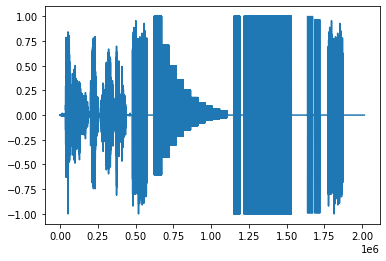

In [30]:
fig, ax = plt.subplots(1, 1)
ax.plot(wwvh_test_signal())
plt.show()

*Why are the sinusoids asymetric?*

In [31]:
scipy.io.wavfile.write("test.wav", Fs, wwvh_test_signal())

Voice clip: 10.0 seconds.
White noise: 2.0 seconds.
Coherent tones: 10.0 seconds.
Adding 0.0 seconds of blank time to end on an even second...
The chirps take 8.0 seconds total.
Pulses: 2.0 seconds.
Adding same gaussian sequence as before.
Total length: 42.0 seconds.


<ipython-input-27-81d3b92dca0c>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, voice_audio = scipy.io.wavfile.read('voiceintro.wav')


This, as of writing, outputs a 64 bit float wav file. The original MATLAB file outputs 16 bit PCM. I converted the output to the PCM format using Audacity.

In [32]:
!exiftool test.wav

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = "en.UTF-8",
	LC_ALL = (unset),
	LC_CTYPE = "C.UTF-8",
	LANG = "en.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
ExifTool Version Number         : 11.88
File Name                       : test.wav
Directory                       : .
File Size                       : 15 MB
File Modification Date/Time     : 2022:01:20 19:50:15-05:00
File Access Date/Time           : 2022:01:20 19:29:09-05:00
File Inode Change Date/Time     : 2022:01:20 19:50:15-05:00
File Permissions                : rw-rw-r--
File Type                       : WAV
File Type Extension             : wav
MIME Type                       : audio/x-wav
Encoding                        : Microsoft IEEE float
Num Channels                    : 1
Sample Rate                     : 48000
Avg Bytes Per Sec               : 384000
Bits Per Sample                 : 64
Nu

## Tests

In [33]:
reference_path = "../zenodo.5602094/"

In [34]:
!exiftool "../zenodo.5602094/test.wav"

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = "en.UTF-8",
	LC_ALL = (unset),
	LC_CTYPE = "C.UTF-8",
	LANG = "en.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
ExifTool Version Number         : 11.88
File Name                       : test.wav
Directory                       : ../zenodo.5602094
File Size                       : 3.8 MB
File Modification Date/Time     : 2022:01:19 20:46:01-05:00
File Access Date/Time           : 2022:01:20 12:35:38-05:00
File Inode Change Date/Time     : 2022:01:19 20:46:49-05:00
File Permissions                : rw-rw-r--
File Type                       : WAV
File Type Extension             : wav
MIME Type                       : audio/x-wav
Encoding                        : Microsoft PCM
Num Channels                    : 1
Sample Rate                     : 48000
Avg Bytes Per Sec               : 96000
Bits Per Sample               

In [35]:
signal = wwvh_test_signal()

Voice clip: 10.0 seconds.
White noise: 2.0 seconds.
Coherent tones: 10.0 seconds.
Adding 0.0 seconds of blank time to end on an even second...
The chirps take 8.0 seconds total.
Pulses: 2.0 seconds.
Adding same gaussian sequence as before.
Total length: 42.0 seconds.


<ipython-input-27-81d3b92dca0c>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, voice_audio = scipy.io.wavfile.read('voiceintro.wav')


In [36]:
with wave.open(reference_path + "test.wav", 'rb') as reference_file:
    reference_duration = reference_file.getnframes() / reference_file.getframerate()
    expected_test_duration = sum([x[1] for x in signal_sequence])
    assert reference_duration == expected_test_duration
    
    assert reference_file.getframerate() == Fs
    
    actual_duration = len(signal) / Fs
    assert reference_duration == actual_duration
    
    assert reference_file.getnframes() == len(signal)

In [37]:
original_rate, original_audio = scipy.io.wavfile.read(reference_path + 'test.wav')

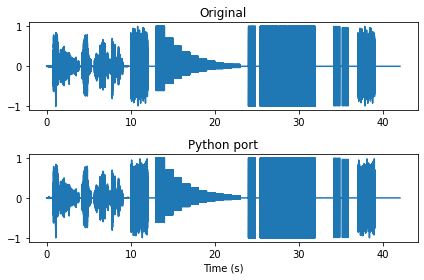

In [38]:
fig, axs = plt.subplots(2, 1)

axs[0].set_title("Original")
axs[0].plot(np.arange(0, len(original_audio) / Fs, dt),
            original_audio / np.max(np.abs(original_audio)))

axs[1].set_title("Python port")
axs[1].plot(np.arange(0, len(signal) / Fs, dt), signal)
axs[1].set_xlabel("Time (s)")

fig.tight_layout()
plt.show()

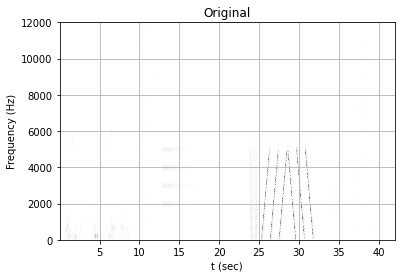

In [39]:
plot_spectrogram("Original", original_audio, Fs)
plt.show()

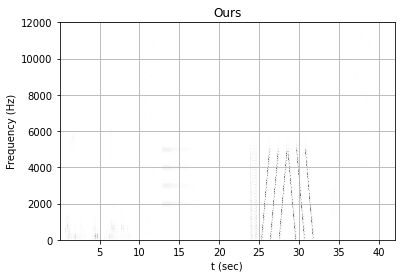

In [40]:
plot_spectrogram("Ours", signal, Fs)

In [41]:
def axis_plot_spectrogram(ax, x, fs):
    f, t, Sxx = spectrogram(x, fs)
    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")

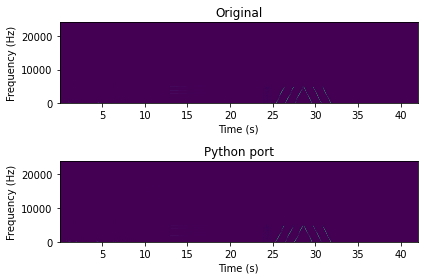

In [42]:
fig, axs = plt.subplots(2, 1)

axs[0].set_title("Original")
axis_plot_spectrogram(axs[0], original_audio, Fs)

axs[1].set_title("Python port")
axis_plot_spectrogram(axs[1], signal, Fs)

fig.tight_layout()
plt.show()

Let's try the matplotlib spectrogram routine instead:

In [43]:
def axis_plot_spectrogram(ax, x, fs):
    ax.specgram(x, NFFT=1024, Fs=fs, noverlap=900)

/home/aidan/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


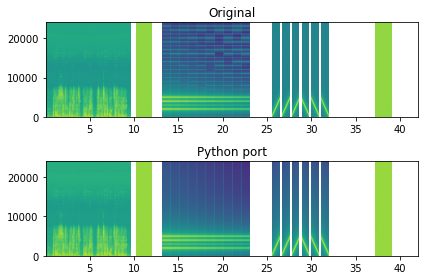

In [44]:
fig, axs = plt.subplots(2, 1)

axs[0].set_title("Original")
axis_plot_spectrogram(axs[0], original_audio, Fs)

axs[1].set_title("Python port")
axis_plot_spectrogram(axs[1], signal, Fs)

fig.tight_layout()
plt.show()

Not sure why these plots aren't as clear to read as ones generated by other programs (i.e. Mathematica).